In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import warnings
import gc
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, cross_validate
from lightgbm import LGBMRegressor

In [4]:
df = pd.read_parquet('data/meters/combinedmeters/meter_data_filtered1.parquet')

for c in df.select_dtypes('float64'):
    df[c] = df[c].astype('float32')
for c in df.select_dtypes('int64'):
    df[c] = df[c].astype('int32')
gc.collect()

print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Date range: {df['timestamp_local'].min()} to {df['timestamp_local'].max()}")
print(f"Buildings: {df['building_id'].nunique()}")
df.head()

Data loaded: 25,559,768 rows, 9 columns
Date range: 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Buildings: 1572


,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.850006,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 08:00:00,4.4
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.250000,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 09:00:00,4.4
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.500000,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 10:00:00,4.4
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.399994,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 11:00:00,4.4
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.250000,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 12:00:00,5.0


Feature Engineering

In [5]:
# --- Feature Engineering ---

# Convert timestamps to datetime if not already
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'])
df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])

# Extract time-based features
df['hour'] = df['timestamp_local'].dt.hour
df['day_of_week'] = df['timestamp_local'].dt.dayofweek
df['day_of_month'] = df['timestamp_local'].dt.day
df['month'] = df['timestamp_local'].dt.month
df['year'] = df['timestamp_local'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create cyclical features for time variables
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Encode categorical variables
le = LabelEncoder()
df['building_id_enc'] = le.fit_transform(df['building_id'])
df['site_id_enc'] = le.fit_transform(df['site_id'])

# Check if primaryspaceusage is already categorical
if df['primaryspaceusage'].dtype == 'object':
    print("primaryspaceusage is already categorical")
else:
    print("Converting primaryspaceusage to categorical")
    df['primaryspaceusage'] = df['primaryspaceusage'].astype('category')

# Show the new features
print("\nDataFrame after feature engineering:")
print(f"Shape: {df.shape}")
df.head()

primaryspaceusage is already categorical

DataFrame after feature engineering:
Shape: (25559768, 23)


,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature,hour,...,year,is_weekend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,building_id_enc,site_id_enc
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.850006,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 08:00:00,4.4,0,...,2016,0,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025,0,0
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.250000,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 09:00:00,4.4,1,...,2016,0,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025,0,0
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.500000,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 10:00:00,4.4,2,...,2016,0,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025,0,0
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.399994,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 11:00:00,4.4,3,...,2016,0,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025,0,0
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.250000,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 12:00:00,5.0,4,...,2016,0,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025,0,0


Preparing data for the models

Square meters (sqm) by building from highest to lowest:
                      building_id           sqm
10377200  Gator_assembly_Kimberly  81290.101562
12390859         Hog_office_Byron  80038.203125
21717707         Rat_office_Colby  79000.398438
21352659           Rat_health_Guy  76141.203125
7899301      Fox_assembly_Bradley  75207.796875
...                           ...           ...
10588927    Gator_assembly_Virgie     44.700001
1364338      Bear_parking_Bridget     36.000000
10234905    Gator_assembly_Bailey     34.000000
10278724     Gator_assembly_Daisy     33.099998
18110140    Panther_retail_Rachel     26.299999

[1572 rows x 2 columns]

Summary statistics:
Minimum sqm: 26.30
Maximum sqm: 81290.10
Average sqm: 8356.64
Total buildings: 1572


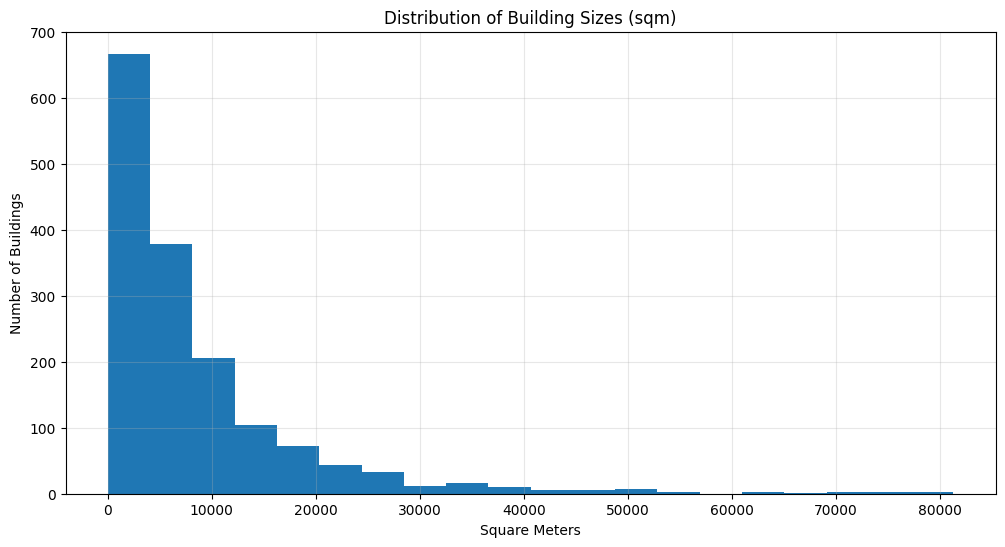


Size category distribution:
sqm_category
Large         10612500
Medium         9259543
Small          3253874
Very Large     2433851
Name: count, dtype: int64


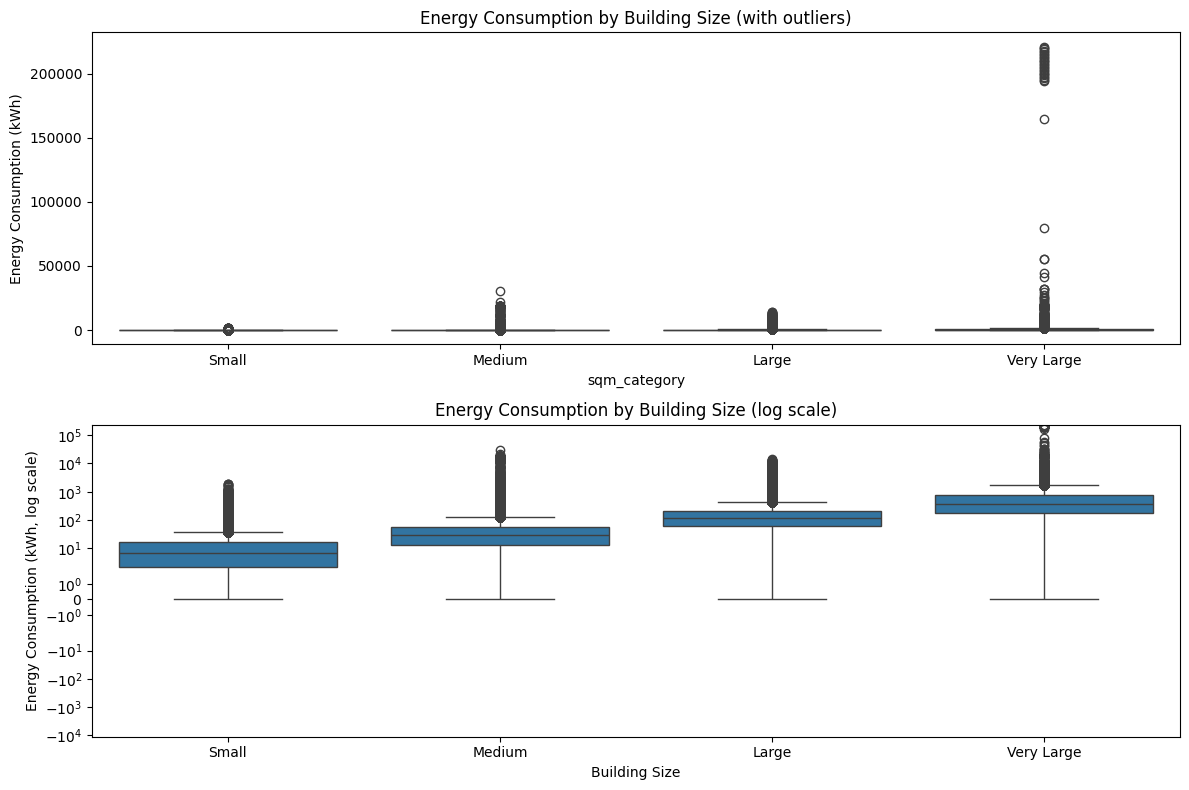

In [6]:
# Get unique building_id and their sqm values
building_sqm = df[['building_id', 'sqm']].drop_duplicates().sort_values('sqm', ascending=False)

# Check if we have numeric values
if building_sqm['sqm'].dtype != 'float64' and building_sqm['sqm'].dtype != 'int64':
    building_sqm['sqm'] = pd.to_numeric(building_sqm['sqm'], errors='coerce')

# Display results
print(f"Square meters (sqm) by building from highest to lowest:")
print(building_sqm)

# Optional: Display summary statistics
print("\nSummary statistics:")
print(f"Minimum sqm: {building_sqm['sqm'].min():.2f}")
print(f"Maximum sqm: {building_sqm['sqm'].max():.2f}")
print(f"Average sqm: {building_sqm['sqm'].mean():.2f}")
print(f"Total buildings: {len(building_sqm)}")

# Optional: Plot distribution
plt.figure(figsize=(12, 6))
plt.hist(building_sqm['sqm'], bins=20)
plt.title('Distribution of Building Sizes (sqm)')
plt.xlabel('Square Meters')
plt.ylabel('Number of Buildings')
plt.grid(alpha=0.3)
plt.show()
# Create custom size categories based on meaningful thresholds
# These thresholds should be adjusted based on your specific data
df['sqm_category'] = pd.cut(
    df['sqm'],
    bins=[0, 1000, 5000, 20000, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very Large'],
    include_lowest=True
)

df['sqm_category'] = df['sqm_category'].astype('category')
print("\nSize category distribution:")
print(df['sqm_category'].value_counts())

# Create derived features
df['energy_intensity'] = df['meter_reading'] / df['sqm']  # kWh per sqm
df['log_sqm'] = np.log1p(df['sqm'])  # Log transform often helps with size variables

# Better visualization that handles outliers
plt.figure(figsize=(12, 8))

# Create subplot for regular view
plt.subplot(2, 1, 1)
sns.boxplot(x='sqm_category', y='meter_reading', data=df)
plt.title('Energy Consumption by Building Size (with outliers)')
plt.ylabel('Energy Consumption (kWh)')

# Create subplot for log-scaled view to better see distribution
plt.subplot(2, 1, 2)
sns.boxplot(x='sqm_category', y='meter_reading', data=df)
plt.yscale('symlog')  # Symmetric log scale handles zeros and negative values
plt.title('Energy Consumption by Building Size (log scale)')
plt.ylabel('Energy Consumption (kWh, log scale)')
plt.xlabel('Building Size')

plt.tight_layout()
plt.show()

Preparing data for the models

In [7]:
# --- Model Data Preparation ---

# Define features and target
feature_cols = [
    # Building/site identifiers
    'building_id_enc', 'site_id_enc',
    
    # Building characteristics
    'primaryspaceusage', 'sqm', 'sqm_category', 'log_sqm', 'energy_intensity',
    
    # Time features
    'hour', 'day_of_week', 'month', 'is_weekend',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    
    # Weather data
    'airTemperature'
]

# Verify all features exist in the dataframe
missing_cols = [col for col in feature_cols if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    feature_cols = [col for col in feature_cols if col in df.columns]

# Prepare features, target, and groups for cross-validation
X = df[feature_cols]
y = df['meter_reading']  # Target variable
groups = df['building_id_enc']  # Group by building for cross-validation

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of groups: {len(groups.unique())}")

# Check for missing values
print("\nMissing values in features:")
print(X.isna().sum())

X shape: (25559768, 18)
y shape: (25559768,)
Number of groups: 1572

Missing values in features:
building_id_enc          0
site_id_enc              0
primaryspaceusage        0
sqm                      0
sqm_category             0
log_sqm                  0
energy_intensity         0
hour                     0
day_of_week              0
month                    0
is_weekend               0
hour_sin                 0
hour_cos                 0
day_sin                  0
day_cos                  0
month_sin                0
month_cos                0
airTemperature       16514
dtype: int64


In [ ]:
# --- Diagnostics and Data Cleaning ---
print("Running data diagnostics...")

# Check for NaN values in input features
print("NaN values by column:")
print(X.isna().sum())

# Check for infinity values
inf_cols = []
for col in X.select_dtypes(include=['float32', 'float64']).columns:
    inf_count = np.isinf(X[col]).sum()
    if inf_count > 0:
        inf_cols.append(col)
        print(f"Infinity values in {col}: {inf_count}")

# Fix energy_intensity if it has infinities
if 'energy_intensity' in X.columns:
    inf_mask = np.isinf(X['energy_intensity'])
    if inf_mask.sum() > 0:
        print(f"Fixing {inf_mask.sum()} infinity values in energy_intensity")
        # Replace with median for the building size category
        median_by_category = X.loc[~inf_mask].groupby('sqm_category')['energy_intensity'].median()
        
        for category, median_value in median_by_category.items():
            category_inf_mask = (X['sqm_category'] == category) & inf_mask
            X.loc[category_inf_mask, 'energy_intensity'] = median_value
            
        # Any remaining infinities get global median
        if np.isinf(X['energy_intensity']).any():
            global_median = X.loc[~np.isinf(X['energy_intensity']), 'energy_intensity'].median()
            X.loc[np.isinf(X['energy_intensity']), 'energy_intensity'] = global_median
            
    # Also check for extreme values and clip them
    q999 = X['energy_intensity'].quantile(0.999)
    q001 = X['energy_intensity'].quantile(0.001)
    X['energy_intensity'] = X['energy_intensity'].clip(q001, q999)
    
    print("Energy intensity range after fixing:", X['energy_intensity'].min(), "to", X['energy_intensity'].max())

# # Make sure all categorical columns are properly encoded
# for col in cat_features:
#     if col in X.columns:
#         X[col] = X[col].astype('category')

Running data diagnostics...
NaN values by column:
building_id_enc          0
site_id_enc              0
primaryspaceusage        0
sqm                      0
sqm_category             0
log_sqm                  0
energy_intensity         0
hour                     0
day_of_week              0
month                    0
is_weekend               0
hour_sin                 0
hour_cos                 0
day_sin                  0
day_cos                  0
month_sin                0
month_cos                0
airTemperature       16514
dtype: int64
Energy intensity range after fixing: 0.0 to 0.46844053


NameError: name 'cat_features' is not defined

In [12]:
# Define categorical features (including sqm_category)
cat_features = ['building_id_enc', 'primaryspaceusage', 'site_id_enc', 'sqm_category']
cat_features = [c for c in cat_features if c in X.columns]

# Pre-process categorical features for LightGBM
for col in cat_features:
    if col in X.columns:
        X[col] = X[col].astype('category')

Light GBM model running

In [ ]:
# --- LightGBM Only ---
print("Running LightGBM model...")

# Set up cross-validation
gkf = GroupKFold(n_splits=5)
cv_splits = list(gkf.split(X, y, groups))

# LightGBM with categorical features
start_time = time.time()
lgb = LGBMRegressor(
    objective='regression',
    learning_rate=0.05, 
    n_estimators=600,
    subsample=0.8, 
    colsample_bytree=0.8,
    num_leaves=63, 
    random_state=42,
    categorical_feature=cat_features
)

# Train and evaluate
lgb_cv_results = cross_validate(
    lgb, X, y,
    cv=cv_splits,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    return_train_score=True
)

lgb_scores = -lgb_cv_results['test_score']
lgb_time = time.time() - start_time
print(f"LightGBM MAE: {lgb_scores.mean():.4f} ± {lgb_scores.std():.4f} (took {lgb_time:.1f}s)")

# Save results
lgb_results = {
    'model': 'LightGBM',
    'mae': lgb_scores.mean(), 
    'std': lgb_scores.std(),
    'time': lgb_time
}

Running LightGBM model...
LightGBM MAE: 30.4071 ± 4.5360 (took 24556.9s)


In [13]:
# Train a final model on all data and examine feature importance
final_lgb = LGBMRegressor(
    objective='regression',
    learning_rate=0.05, 
    n_estimators=600,
    subsample=0.8, 
    colsample_bytree=0.8,
    num_leaves=63, 
    random_state=42,
    categorical_feature=cat_features
)

final_lgb.fit(X, y)

# Plot feature importance
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_lgb.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Drivers of Building Energy Consumption')
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=building_id_enc,primaryspaceusage,site_id_enc,sqm_category, categorical_column=0,1,2 will be ignored. Current value: categorical_feature=building_id_enc,primaryspaceusage,site_id_enc,sqm_category
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 25559768, number of used features: 18
[LightGBM] [Info] Start training from score 144.098942


KeyboardInterrupt: 